In [2]:
#nettoyage variables
%reset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#read csv file
data = pd.read_csv('data/stat_acc_V3_cleared.csv', sep=';')
new_data = pd.read_csv('data/stat_acc_V3_new.csv', sep=';')


In [4]:
#executer le code du fichier preparation.py
%run preparation.ipynb

In [5]:
# Identifier les attributs fortement corrélés

old_new_data = new_data.copy()

# Créer une matrice de corrélation
corr_matrix = new_data.corr().abs()

# Identifiez les paires d'attributs fortement corrélés
threshold = 0.8  # Définissez votre propre seuil de corrélation
highly_correlated_pairs = []

# Parcourir la matrice de corrélation
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            highly_correlated_pairs.append(pair)

#verifier les paires d'attributs fortement corrélés
# print(highly_correlated_pairs)

# Afficher les paires d'attributs fortement corrélés
for pair in highly_correlated_pairs:
    print("Attribut 1:", pair[0])
    print("Attribut 2:", pair[1])

    #suppression d'une des deux colonnes fortement corrélées (ici on supprime la colonne 'an_nais' jugée moins pertinente)
    new_data = new_data.drop(pair[0], axis=1)

    print()

#export csv new_data
new_data.to_csv('data/stat_acc_V3_new.csv', sep=';', index=False)

#obtenir le nombre de colonnes avant et après suppression
print("Nombre de colonnes avant suppression: ", len(data.columns))
print("Nombre de colonnes après suppression de la préparation: ", len(old_new_data.columns))
print("Nombre de colonnes après suppression: ", len(new_data.columns))
print()

#print pourcentage de réduction
print("Pourcentage de réduction de new_data par rapport à old_new_data: ", round((len(data.columns) - len(new_data.columns)) / len(data.columns) * 100, 2), "%")

#print pourcentage de réduction de new_data par rapport à old_new_data
print("Pourcentage de réduction de new_data par rapport à old_new_data: ", round((len(old_new_data.columns) - len(new_data.columns)) / len(old_new_data.columns) * 100, 2), "%")

Attribut 1: an_nais
Attribut 2: age



Nombre de colonnes avant suppression:  21
Nombre de colonnes après suppression de la préparation:  16
Nombre de colonnes après suppression:  15

Pourcentage de réduction de new_data par rapport à old_new_data:  28.57 %
Pourcentage de réduction de new_data par rapport à old_new_data:  6.25 %


### Bonus : PCA

Pourcentage de réduction de data sans les 6 premières colonnes inutiles:  6.25 %
Pourcentage de réduction totale de data:  28.57 %


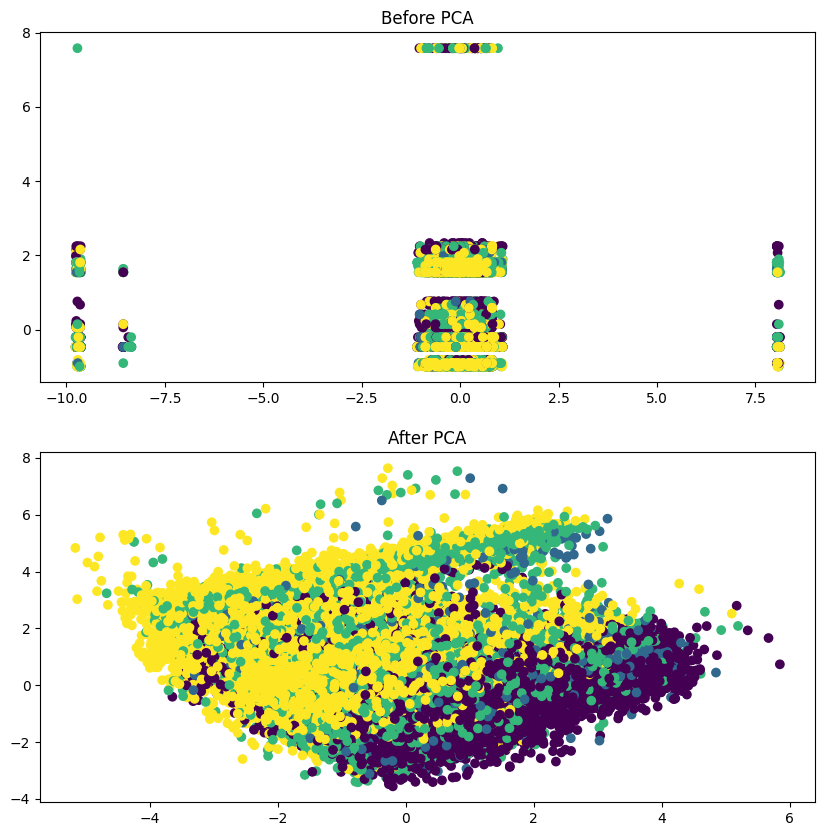

In [6]:
#Réduction de dimension avec PCA sur le dataset data avec graphique de visualisation avant et après réduction
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = data.iloc[:, 7:21].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()

pca.fit(X_scaled)

pca_data = pca.transform(X_scaled)

# print(len(pca_data[0]))
# print(len(data.columns)-6)

dates = data['date']

#ajouter une colonne date au dataset pca_data avec les dates
pca_data = np.c_[pca_data, dates]


#affichage du pourcentage de réduction de data 
print("Pourcentage de réduction de data sans les 6 premières colonnes inutiles: ", round((len(data.columns) - 5 - len(pca_data[0])) / (len(data.columns)-5) * 100, 2), "%")

print("Pourcentage de réduction totale de data: ", round((len(data.columns)- len(pca_data[0])) / (len(data.columns)) * 100, 2), "%")


#visualisation des données avant réduction
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=data['descr_grav'])
plt.title('Before PCA')

#graphique de visualisation avant et après réduction
plt.subplot(2, 1, 2)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data['descr_grav'])
plt.title('After PCA')

plt.show()


### Clustering avec sklearn 

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://www.kaggle.com/code/lucaspcarlini/clustering-and-visualisation-using-folium-maps
import plotly.graph_objects as go
import webbrowser
from sklearn.cluster import KMeans
import json
coordinates = data[['latitude', 'longitude']]
# for make cluster variable
n = 5 # 5 semble adéquat pour avoir DOM TOM + séparation nord sud centre France
kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(coordinates)

labels = kmeans.labels_
new_data['cluster_labels'] = labels # get label from dataframe
print(new_data['cluster_labels'].value_counts())

#preds = kmeans.fit_predict(new_data)


# Centroide 
centroids = kmeans.cluster_centers_

#export centroids to json file
with open('json/centroids.json', 'w') as f:
    json.dump(centroids.tolist(), f)

# graphiques de visualisation des clusters, avec les attributs latitude et longitude + centroide
#plt.scatter(new_data['latitude'], new_data['longitude'], c=new_data['cluster_labels'], s=50, cmap='viridis')
#plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
#plt.show()
#predicted_labels, cluster_centroids = kmeans_clustering(coordinates, n_clusters)


fig = go.Figure()

# Data point
for cluster_label in range(n):
    cluster_data = new_data[new_data['cluster_labels'] == cluster_label]
    fig.add_trace(go.Scattergeo(
        lon = cluster_data['longitude'],
        lat = cluster_data['latitude'],
        mode = 'markers',
        marker = dict(
            size = 8,
            color = cluster_label,
            line = dict(width = 1, color = 'rgba(0, 0, 0, 0.5)'),
            opacity = 0.8
        ),
        name = f'Cluster {cluster_label}'
    ))

# Centroid red cross
for centroid_label, centroid in enumerate(centroids):
    fig.add_trace(go.Scattergeo(
        lon=[centroid[1]],
        lat=[centroid[0]],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='x',
        ),
    ))

# Map layout
fig.update_layout(
    title = 'Carte des clusters via K-Means sklearn',
    geo = dict(
        resolution = 110,
        showland = True,
        showlakes = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
        lakecolor = 'rgb(255, 255, 255)',
        projection_type = 'natural earth'
    )
)

fig.write_html('map_clusters.html')
webbrowser.open("map_clusters.html")
print('map_clusters.html')

preds = kmeans.fit_predict(new_data)

# all score coef
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(new_data, preds)
print("Silhouette Coefficient :", silhouette_avg)

from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(new_data, preds)
print("Calinski-Harabasz Index :", ch_score)

from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(new_data, preds)
print("Davies-Bouldin Index :", db_score)


4    32418
0    24409
3    16053
1      502
2      258
Name: cluster_labels, dtype: int64
map_clusters.html


KeyboardInterrupt: 

### Clustering en scratch

- Silhouette Coefficient entre -1 et 1 plus on est proche de 1 plus on est précis 
- davies_bouldin entre 0 et + inf plus on est proche de 0 mieux c'est 
- calinski_harabas entre 0 et + inf plus on est proche de inf mieux c'est 

In [108]:
import plotly.graph_objects as go
import webbrowser
import math
import numpy as np
import matplotlib.pyplot as plt

# Dist Manhattan
def distL1(lat1, lon1, lat2, lon2):
    return abs(lat2 - lat1) + abs(lon2 - lon1)
#a
# Dist euclidienne
def distL2(lat1, lon1, lat2, lon2):
    return math.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)

# Dist Haversine (distance entre 2 pts sur la Terre)
def distHaversine(lat1, lon1, lat2, lon2):
    radius = 6371  # Rayon de la Terre en kilomètres
    dlat = math.radians(lat2 - lat1)    # distance btw 2 pts en radians
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

def kmeans_clustering(new_data, n_clusters, max_iterations=100):
    np.random.seed(0)
    centroids = new_data[np.random.choice(range(len(new_data)), size=n_clusters, replace=False)]
    
    for _ in range(max_iterations):
        labels = np.zeros(len(new_data)) # Init labels pour chaque point
         # Assignation des points aux clusters les plus proches
        for i, point in enumerate(new_data):
            min_distance = float('inf')
            for j, centroid in enumerate(centroids):
                dist = distL1(point[0], point[1], centroid[0], centroid[1]) # Manhattan distance
                #dist = distL2(point[0], point[1], centroid[0], centroid[1])# euclienean distance
                #dist = distHaversine(point[0], point[1], centroid[0], centroid[1]) # dist btw point and centroid
                if dist < min_distance:
                    min_distance = dist
                    labels[i] = j  # Attribution du label du cluster au point
        # Update centroids 
        new_centroids = np.zeros_like(centroids) # Calcul des nouveaux centroids en prenant la moyenne des points dans chaque cluster
        cluster_counts = np.zeros(n_clusters)
        for i in range(len(new_data)):
            cluster_index = int(labels[i])
            new_centroids[cluster_index] += new_data[i] # add coord point to cluster
            cluster_counts[cluster_index] += 1 # Count  nb point in each cluster
        for j in range(n_clusters):
            if cluster_counts[j] > 0: # if cluster not empty to avoid div by 0 
                    new_centroids[j] = np.divide(new_centroids[j], cluster_counts[j]) # average of point coord to get new centroid by dividing by nb point in cluster
        
        if np.allclose(centroids, new_centroids): # compare if old and new centroids are enough close if yes stop all
            break
        
        centroids = new_centroids # update centroide 
    
    return labels, centroids

coordinates = new_data[['latitude', 'longitude']].values
n_clusters = 5

predicted_labels, cluster_centroids = kmeans_clustering(coordinates, n_clusters)

new_data['cluster_labels'] = predicted_labels
print(new_data['cluster_labels'].value_counts())

fig = go.Figure()


for cluster_label in range(n_clusters):
    cluster_data = new_data[new_data['cluster_labels'] == cluster_label]
    fig.add_trace(go.Scattergeo(
        lon = cluster_data['longitude'],
        lat = cluster_data['latitude'],
        mode = 'markers',
        marker = dict(
            size = 8,
            color = cluster_label,
            line = dict(width = 1, color = 'rgba(0, 0, 0, 0.5)'),
            opacity = 0.8
        ),
        name = f'Cluster {cluster_label}'
    ))
    
# Red cross centroid
for centroid_label, centroid in enumerate(centroids):
    fig.add_trace(go.Scattergeo(
        lon=[centroid[1]],
        lat=[centroid[0]],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='x',
            line=dict(width=1, color='red'),
        ),
    ))
# Map layout
fig.update_layout(
    title = 'Carte des clusters via scratch',
    geo = dict(
        resolution = 110,
        showland = True,
        showlakes = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
        lakecolor = 'rgb(255, 255, 255)',
        projection_type = 'natural earth'
    )
)

fig.write_html('map_clusters.html')
webbrowser.open("map_clusters.html")
print('map_clusters.html')


cluster_labels
3.0    36692
0.0    19503
2.0    16685
4.0      502
1.0      258
Name: count, dtype: int64
map_clusters.html
